In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from sklearn.pipeline import Pipeline

In [52]:
game_stats=pd.read_csv('game_stats_results.csv')
nlp=pd.read_csv('nlp_results.csv')

In [53]:
columns=['home_team','away_team','final_result','predict_stats','proba_stats_home','proba_stats_draw','proba_stats_away']
game_stats=game_stats.loc[:,columns]

In [54]:
game_stats.head(1)

,home_team,away_team,final_result,predict_stats,proba_stats_home,proba_stats_draw,proba_stats_away
0,Hertha Berlin,Hoffenheim,Away,-1,0.04097,0.120401,0.838629


In [55]:
columns=['team_home','team_away','result','proba_home','proba_draw','proba_away']
nlp=nlp.loc[:,columns]

In [56]:
nlp.head(1)

,team_home,team_away,result,proba_home,proba_draw,proba_away
0,FC Koln,Freiburg,Away,0.500788,0.119366,0.379846


In [57]:
def get_stats(row,column):
    home = row['team_home']
    away = row['team_away']
    df=game_stats.query(f'(home_team == "{home}") & (away_team == "{away}")')
    if len(df)==0:
        return np.nan
    else:
        return df[column].values[0]

In [58]:
df=nlp
columns=['proba_stats_home', 'proba_stats_draw', 'proba_stats_away']
for column in columns:
    df[column]=df.apply(lambda row: get_stats(row,column), axis=1)
df=df.dropna()


# Draw Exploratory

In [59]:
X_proba=df[['proba_draw','proba_stats_draw','result']]
X_proba.result=X_proba.result.apply(lambda x: 1 if x == 'Draw' else 0)

In [60]:
X_proba.proba_draw_label=pd.qcut(X_proba.proba_draw,4, labels=range(4,0,-1))
X_proba.proba_stats_draw_label=pd.qcut(X_proba.proba_stats_draw,4, labels=range(4,0,-1))

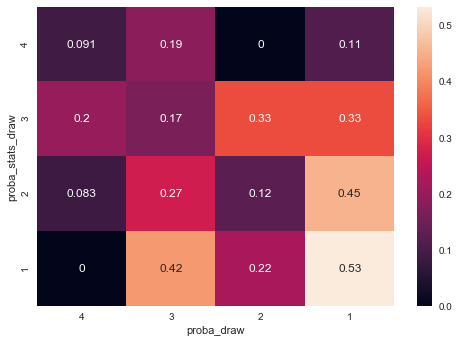

In [61]:
x=pd.crosstab(index=X_proba.proba_stats_draw_label, columns=X_proba.proba_draw_label, values=X_proba.result, aggfunc='mean')
sns.heatmap(x, annot=True)

# Draw Modeling

In [62]:
X = X_proba.drop('result', axis=1)
y = X_proba['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [63]:
param_grid = {'max_depth': [1, 5, 10 , 15, 20],
              'criterion': ['gini', 'entropy'],
              'splitter': ['random', 'best'],
              'min_samples_split': [2, 4, 6, 8, 10, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]}

In [64]:
model_draw = DecisionTreeClassifier()
gsearch = GridSearchCV(estimator=model_draw, param_grid=param_grid, n_jobs=-1, cv=3)

In [65]:
model_draw = gsearch.fit(X_train, y_train)

In [66]:
# Best params by the best score

print(model_draw.best_params_, model_draw.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'} 0.7756410256410257


In [67]:
model_draw = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=20, min_samples_leaf=10, min_samples_split=20)

In [68]:
pipe_draw = Pipeline(steps=[('model', model_draw)])

In [69]:
pipe_draw.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=20,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='random'))],
         verbose=False)

In [70]:
pipe_draw.score(X_test, y_test)

0.8461538461538461

In [71]:
precision_score(y_test, pipe_draw.predict(X_test), average='weighted')

0.8704453441295547

In [72]:
results = cross_val_score(pipe_draw, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.6408333333333334, 0.18949677511181498)

# Home Exploratory

In [73]:
X_proba=df[['proba_home','proba_stats_home','result']]

In [74]:
X_proba.result=X_proba.result.apply(lambda x: 1 if x == 'Home' else 0)

In [75]:
X_proba.proba_home_label=pd.qcut(X_proba.proba_home,4, labels=range(4,0,-1))
X_proba.proba_stats_home_label=pd.qcut(X_proba.proba_stats_home,4, labels=range(4,0,-1))

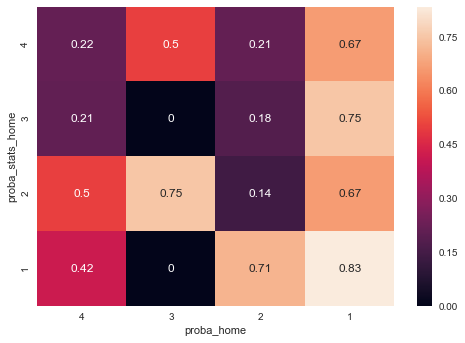

In [76]:
x=pd.crosstab(index=X_proba.proba_stats_home_label, columns=X_proba.proba_home_label, values=X_proba.result, aggfunc='mean')
sns.heatmap(x, annot=True)

# Home Modeling

In [77]:
X = X_proba.drop('result', axis=1)
y = X_proba['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [78]:
param_grid = {'max_depth': [1, 5, 10 , 15, 20],
              'criterion': ['gini', 'entropy'],
              'splitter': ['random', 'best'],
              'min_samples_split': [2, 4, 6, 8, 10, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]}

In [79]:
model_home = DecisionTreeClassifier()

In [80]:
gsearch = GridSearchCV(estimator=model_home, param_grid=param_grid, n_jobs=-1, cv=3)
model = gsearch.fit(X_train, y_train)
# Best params by the best score

print(model.best_params_, model.best_score_)

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 6, 'splitter': 'random'} 0.7179487179487181


In [81]:
model_home = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=10, min_samples_leaf=5, min_samples_split=20)

In [82]:
pipe_home = Pipeline(steps=[('model', model_home)])

In [83]:
pipe_home.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5,
                                        min_samples_split=20,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='random'))],
         verbose=False)

In [84]:
pipe_home.score(X_test, y_test)

0.5897435897435898

In [85]:
precision_score(y_test, pipe_home.predict(X_test), average='weighted')

0.5917785917785918

In [86]:
results = cross_val_score(pipe_home, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.6436458333333333, 0.19420586491851888)

# Away Swap-In

In [87]:
X_proba=df[['proba_away','proba_stats_away','result']]

In [88]:
X_proba.result=X_proba.result.apply(lambda x: 1 if x == 'Away' else 0)

In [89]:
X_proba.proba_away_label=pd.qcut(X_proba.proba_away,4, labels=range(4,0,-1))
X_proba.proba_stats_away_label=pd.qcut(X_proba.proba_stats_away,4, labels=range(4,0,-1))

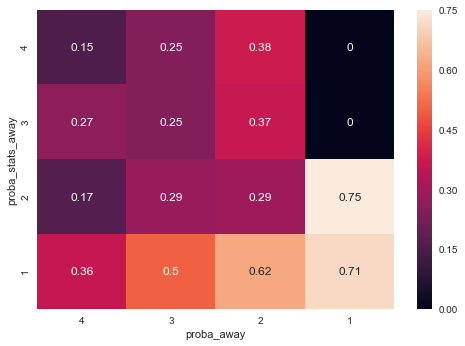

In [90]:
x=pd.crosstab(index=X_proba.proba_stats_away_label, columns=X_proba.proba_away_label, values=X_proba.result, aggfunc='mean')
sns.heatmap(x, annot=True)

# Away Modeling

In [91]:
X = X_proba.drop('result', axis=1)
y = X_proba['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [92]:
param_grid = {'max_depth': [1, 5, 10 , 15, 20],
              'criterion': ['gini', 'entropy'],
              'splitter': ['random', 'best'],
              'min_samples_split': [2, 4, 6, 8, 10, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]}

In [93]:
model_away = DecisionTreeClassifier()

In [94]:
gsearch = GridSearchCV(estimator=model_away, param_grid=param_grid, n_jobs=-1, cv=3)
model = gsearch.fit(X_train, y_train)
# Best params by the best score

print(model.best_params_, model.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 20, 'splitter': 'random'} 0.717948717948718


In [95]:
model_away = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=15, min_samples_leaf=5, min_samples_split=4)

In [96]:
pipe_away = Pipeline(steps=[('model', model_away)])

In [97]:
pipe_away.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=15,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=4,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='random'))],
         verbose=False)

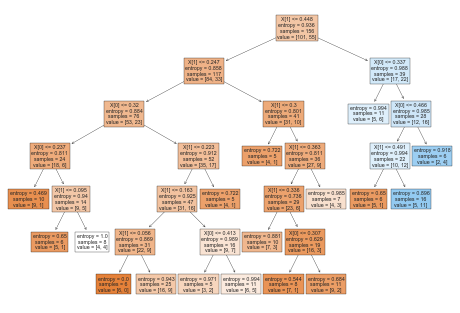

In [109]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
plot_tree(model_away, filled=True)
plt.show()

In [108]:
pipe_away.classes_

array([0, 1], dtype=int64)

In [98]:
pipe_away.score(X_test, y_test)

0.6666666666666666

In [99]:
precision_score(y_test, pipe_away.predict(X_test), average='weighted')

0.6494252873563219

In [100]:
results = cross_val_score(pipe_away, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.5641666666666666, 0.21726040443056652)

In [110]:
import pickle
filename = 'away_model.sav'
pickle.dump(pipe_away, open(filename, 'wb'))

In [112]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6666666666666666
